In [1]:
import os
import random

import numpy as np
from random import seed

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchvision.models import MobileNet_V2_Weights  
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print('Torch version: ', torch.__version__)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('\nMemory Usage')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
Torch version:  2.5.1+cu118
NVIDIA GeForce RTX 3050 Laptop GPU

Memory Usage
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
def plot_graph(train_losses, train_accuracies, valid_losses, valid_accuracies):
    '''
    Input: 
    - train_losses: List of training loss values.
    - train_accuracies: List of training accuracy values.
    - valid_losses: List of validation loss values.
    - valid_accuracies: List of validation accuracy values.
    Return: 
    - Graph of Loss and Accuracy between training and validation datasets.
    '''
    # Subplots
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    
    # Plot loss
    ax[0].plot(train_losses, label='Training Loss')
    ax[0].plot(valid_losses, label='Validation Loss')
    ax[0].legend(fontsize=12, loc='upper right')
    ax[0].set_title('Training and Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    
    # Plot accuracy
    ax[1].plot(train_accuracies, label='Training Accuracy')
    ax[1].plot(valid_accuracies, label='Validation Accuracy')
    ax[1].legend(fontsize=12, loc='lower right')
    ax[1].set_title('Training and Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')

    # Show the plot
    plt.show()

In [4]:
def get_metric(model, dataloader, device, name_model=None):
    '''
        Input: 
        - model: PyTorch model.
        - dataloader: DataLoader object (used to load batches of images and labels).
        - device: Device to run the model on (e.g., 'cuda' or 'cpu').
        - name_model: str, name of the model to display (optional).
        
        Return: 
        - ConfusionMatrixDisplay, accuracy_score, and size of model.
    '''
    model.eval() 
    all_preds = []
    all_labels = []

    with torch.no_grad(): 
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get model predictions
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy()) 
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays for evaluation
    y_preds = np.array(all_preds)
    y_actual = np.array(all_labels)

    print(f"Model: {name_model}")
    print("-" * 50)
    
    labels = ['cocci', 'healthy', 'ncd', 'salmo']

    cm = confusion_matrix(y_actual, y_preds)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot(cmap=plt.cm.Blues)
    
    accuracy = accuracy_score(y_actual, y_preds)
    f1 = f1_score(y_actual, y_preds, average='macro')
    model_size = sum(p.numel() for p in model.parameters())

    print(classification_report(y_actual, y_preds, target_names=labels)) 
    print(f"Accuracy score: {round(accuracy, 2)}") 
    print(f"F1 score (average): {round(f1, 2)}")
    print(f"Model size: {model_size} parameters")

In [5]:
# set state seed
seed(42)

# Open path file of dataset 
dataset_path_new = "../dataset_train_valid_test"

train_dir = os.path.join(dataset_path_new, "train")
valid_dir = os.path.join(dataset_path_new, "valid")
test_dir = os.path.join(dataset_path_new, "test")

In [7]:
# Hyperparameters
batch_size = 50
img_height = 128
img_width = 128
num_classes = 4 
learning_rate = 0.001
num_epochs = 50

In [8]:
# Image transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

In [9]:
# Datasets and DataLoaders
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
valid_dataset = datasets.ImageFolder(valid_dir, transform=data_transforms['valid'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [34]:
class CustomMobileNetV2(nn.Module):
    def __init__(self, num_classes, learning_rate):

        super(CustomMobileNetV2, self).__init__()

        weights = MobileNet_V2_Weights.DEFAULT
        
        self.model = models.mobilenet_v2(weights=weights)
        
        # Freezing layers
        for param in self.model.features.parameters():
            param.requires_grad = False

        self.model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.model.last_channel, num_classes),
        )
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.classifier.parameters(), lr=learning_rate)

    def forward(self, x):
        return self.model(x)

In [11]:
def train_one_epoch(model, optimizer, criterion, train_loader, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    train_accuracy = 100 * correct / total
    return running_loss / len(train_loader), train_accuracy

In [12]:
def validate(model, criterion, valid_loader, device):
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    valid_accuracy = 100 * correct / total
    return valid_loss / len(valid_loader), valid_accuracy

In [13]:
def train(model, optimizer, criterion, train_loader, valid_loader, num_epochs, device):
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_one_epoch(model, optimizer, criterion, train_loader, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        valid_loss, valid_accuracy = validate(model, criterion, valid_loader, device)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%\n')
    
    return train_losses, train_accuracies, valid_losses, valid_accuracies

In [14]:
def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Test Accuracy: {test_accuracy:.2f}%')

In [35]:
classifier = CustomMobileNetV2(num_classes=num_classes, learning_rate=learning_rate)

In [16]:
train_losses, train_accuracies, valid_losses, valid_accuracies = train(classifier.model, classifier.optimizer, classifier.criterion, 
                                                                        train_loader, valid_loader, num_epochs, classifier.device)

Epoch 1/50
Train Loss: 0.5991, Train Accuracy: 81.37%
Validation Loss: 0.3958, Validation Accuracy: 86.57%

Epoch 2/50
Train Loss: 0.3673, Train Accuracy: 87.63%
Validation Loss: 0.3334, Validation Accuracy: 89.69%

Epoch 3/50
Train Loss: 0.3238, Train Accuracy: 89.51%
Validation Loss: 0.3154, Validation Accuracy: 89.93%

Epoch 4/50
Train Loss: 0.2987, Train Accuracy: 89.53%
Validation Loss: 0.3102, Validation Accuracy: 89.33%

Epoch 5/50
Train Loss: 0.2683, Train Accuracy: 90.69%
Validation Loss: 0.2892, Validation Accuracy: 90.77%

Epoch 6/50
Train Loss: 0.2617, Train Accuracy: 91.11%
Validation Loss: 0.2979, Validation Accuracy: 90.17%

Epoch 7/50
Train Loss: 0.2693, Train Accuracy: 90.80%
Validation Loss: 0.2784, Validation Accuracy: 90.29%

Epoch 8/50
Train Loss: 0.2502, Train Accuracy: 91.27%
Validation Loss: 0.2870, Validation Accuracy: 90.53%

Epoch 9/50
Train Loss: 0.2436, Train Accuracy: 91.53%
Validation Loss: 0.2854, Validation Accuracy: 90.29%

Epoch 10/50
Train Loss: 0.24

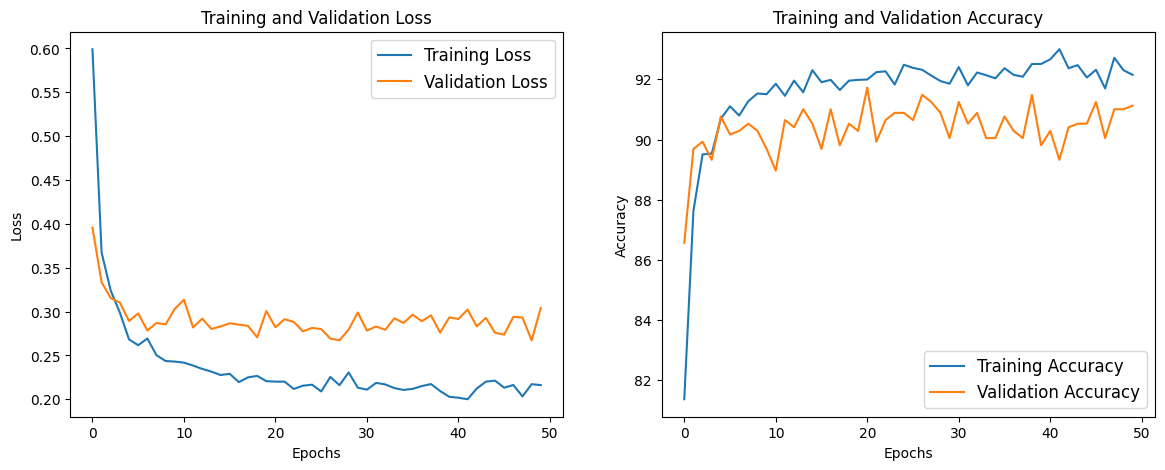

In [17]:
plot_graph(train_losses, train_accuracies, valid_losses, valid_accuracies)

In [18]:
test(classifier.model, test_loader, classifier.device)

Test Accuracy: 90.90%


Model: MobileNetV2
--------------------------------------------------
              precision    recall  f1-score   support

       cocci       0.97      0.93      0.95       231
     healthy       0.91      0.88      0.90       264
         ncd       0.74      0.84      0.79        55
       salmo       0.90      0.94      0.92       284

    accuracy                           0.91       834
   macro avg       0.88      0.90      0.89       834
weighted avg       0.91      0.91      0.91       834

Accuracy score: 0.91
F1 score (average): 0.89
Model size: 2228996 parameters


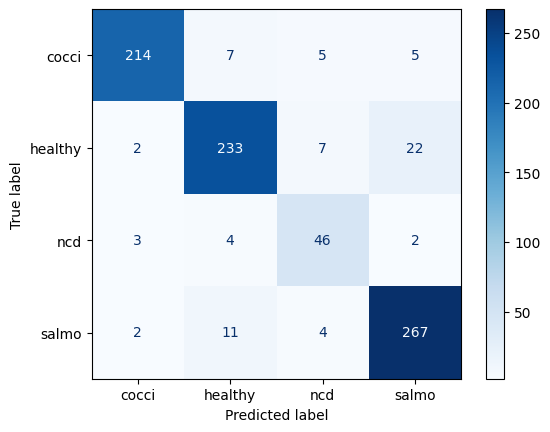

In [19]:
get_metric(classifier.model, valid_loader, classifier.device, name_model="MobileNetV2")


In [20]:
def save_model(model, save_dir, model_name="mobnetv2.pth"):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    save_path = os.path.join(save_dir, model_name)
    
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

In [21]:
save_model(classifier.model, '../model/mobilenetV2')

Model saved to model/mobilenetV2\mobnetv2.pth


In [41]:
def load_model(model, model_path, device='cpu'):
    state_dict = torch.load(model_path, map_location=device)
    missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)
    
    if missing_keys:
        print(f"Missing keys: {missing_keys}")
    if unexpected_keys:
        print(f"Unexpected keys: {unexpected_keys}")
        
    model.to(device)
    model.eval()
    return model

In [23]:
def preprocess_image(img_path, target_size=(128, 128)):
    # Open the image using PIL
    img = Image.open(img_path).convert('RGB')
    
    # Define the transform pipeline for preprocessing
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
    ])
    
    # Apply the transformations to the image
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension
    return img_tensor

In [24]:
def display_image(img_path):
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off') 
    plt.show()

In [25]:
def predict_and_display_image(model, img_path, target_size=(128, 128), class_names=None, device='cpu'):
    # Preprocess the image
    img_tensor = preprocess_image(img_path, target_size)
    
    # Move the tensor to the same device as the model
    img_tensor = img_tensor.to(device)
    
    # Perform the prediction
    with torch.no_grad():
        output = model(img_tensor)  
        prediction = torch.softmax(output, dim=1) 
        predicted_class = torch.argmax(prediction, dim=1).item() 
    
    # Display the image
    display_image(img_path)
    
    # Show the predicted class and confidence
    if class_names:
        class_name = class_names[predicted_class]
        print(f"File: {os.path.basename(img_path)}")
        print(f"Predicted class: {class_name}")
    else:
        print(f"File: {os.path.basename(img_path)}")
        print(f"Predicted class (index): {predicted_class}")
    
    print(f"Prediction confidence: {prediction[0][predicted_class].item():.4f}")

In [26]:
def predict_and_display_random_images(model, img_dir, target_size=(128, 128), class_names=None, device='cpu'):
    img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
    
    random_img_files = random.sample(img_files, 10)
    
    for img_file in random_img_files:
        img_path = os.path.join(img_dir, img_file)
        print(f"\nImage: {img_file}")
        predict_and_display_image(model, img_path, target_size, class_names, device)

In [27]:
class_names = ['Coccidiosis', 'Healthy', 'NewCastleDisease', 'Salmonella']

In [42]:
model_path = '../model/mobilenetV2/mobnetv2.pth' 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = CustomMobileNetV2(num_classes=4, learning_rate=0.001)
model = load_model(model, model_path, device)

Missing keys: ['model.features.0.0.weight', 'model.features.0.1.weight', 'model.features.0.1.bias', 'model.features.0.1.running_mean', 'model.features.0.1.running_var', 'model.features.1.conv.0.0.weight', 'model.features.1.conv.0.1.weight', 'model.features.1.conv.0.1.bias', 'model.features.1.conv.0.1.running_mean', 'model.features.1.conv.0.1.running_var', 'model.features.1.conv.1.weight', 'model.features.1.conv.2.weight', 'model.features.1.conv.2.bias', 'model.features.1.conv.2.running_mean', 'model.features.1.conv.2.running_var', 'model.features.2.conv.0.0.weight', 'model.features.2.conv.0.1.weight', 'model.features.2.conv.0.1.bias', 'model.features.2.conv.0.1.running_mean', 'model.features.2.conv.0.1.running_var', 'model.features.2.conv.1.0.weight', 'model.features.2.conv.1.1.weight', 'model.features.2.conv.1.1.bias', 'model.features.2.conv.1.1.running_mean', 'model.features.2.conv.1.1.running_var', 'model.features.2.conv.2.weight', 'model.features.2.conv.3.weight', 'model.features.2

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11240\3996494258.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)



Image: cocci.382.jpg


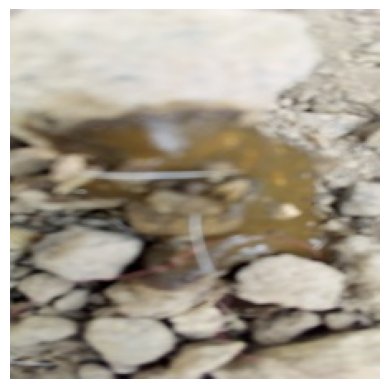

File: cocci.382.jpg
Predicted class: NewCastleDisease
Prediction confidence: 0.3375

Image: cocci.485.jpg


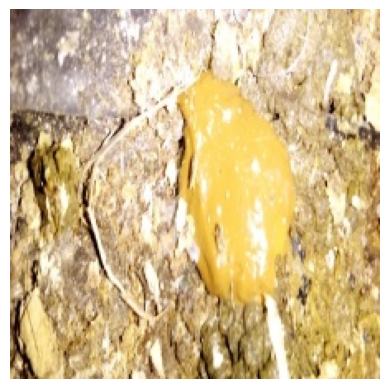

File: cocci.485.jpg
Predicted class: NewCastleDisease
Prediction confidence: 0.3882

Image: healthy.331.jpg


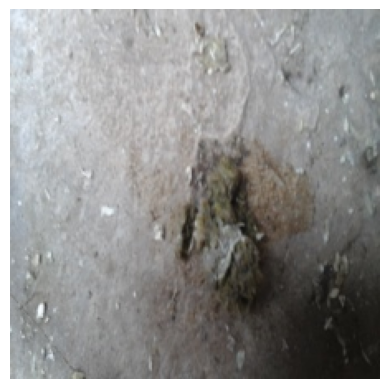

File: healthy.331.jpg
Predicted class: NewCastleDisease
Prediction confidence: 0.3413

Image: ncd.144.jpg


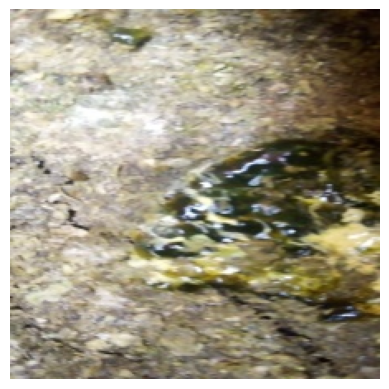

File: ncd.144.jpg
Predicted class: Healthy
Prediction confidence: 0.3092

Image: cocci.1193.jpg


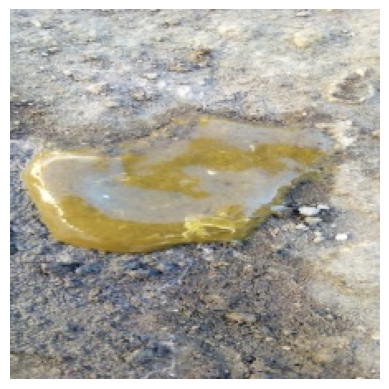

File: cocci.1193.jpg
Predicted class: Coccidiosis
Prediction confidence: 0.4005

Image: healthy.744.jpg


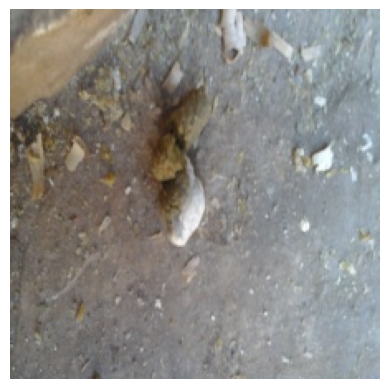

File: healthy.744.jpg
Predicted class: NewCastleDisease
Prediction confidence: 0.3327

Image: cocci.2463.jpg


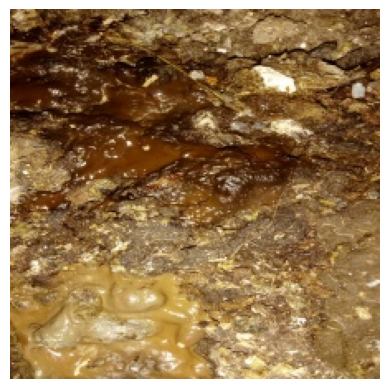

File: cocci.2463.jpg
Predicted class: Coccidiosis
Prediction confidence: 0.2887

Image: salmo.1379.jpg


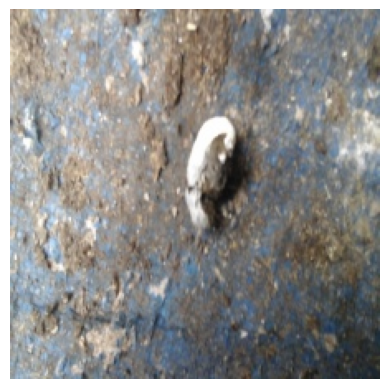

File: salmo.1379.jpg
Predicted class: NewCastleDisease
Prediction confidence: 0.4670

Image: ncd.498.jpg


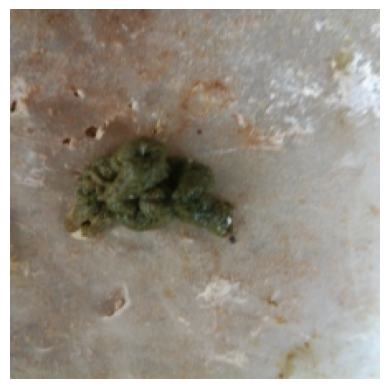

File: ncd.498.jpg
Predicted class: NewCastleDisease
Prediction confidence: 0.3242

Image: salmo.1270.jpg


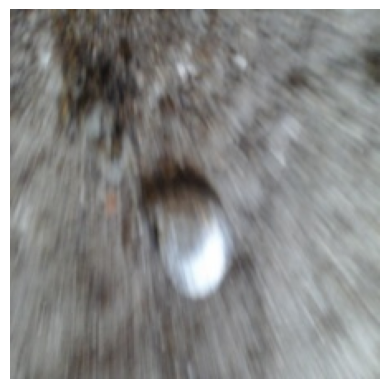

File: salmo.1270.jpg
Predicted class: Healthy
Prediction confidence: 0.2967


In [45]:
img_dir = '../all_new'
predict_and_display_random_images(model, img_dir, class_names=class_names, device=device)